<a href="https://colab.research.google.com/github/mtjon/infompr-group-project/blob/feature%2Ftransformer/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2022 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with a Transformer and Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to create and train a [sequence-to-sequence](https://developers.google.com/machine-learning/glossary#sequence-to-sequence-task) [Transformer](https://developers.google.com/machine-learning/glossary#Transformer) model to translate [Portuguese into English](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en). The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017).

Transformers are deep neural networks that replace CNNs and RNNs with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention). Self attention allows Transformers to easily transmit information across the input sequences.

As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1: Applying the Transformer to machine translation. Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


That's a lot to digest, the goal of this tutorial is to break it down into easy to understand parts. In this tutorial you will:

- Prepare the data.
- Implement necessary components:
  - Positional embeddings.
  - Attention layers.
  - The encoder and decoder.
- Build & train the Transformer.
- Generate translations.
- Export the model.

To get the most out of this tutorial, it helps if you know about [the basics of text generation](./text_generation.ipynb) and attention mechanisms. 

A Transformer is a sequence-to-sequence encoder-decoder model similar to the model in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).
A single-layer Transformer takes a little more code to write, but is almost identical to that encoder-decoder RNN model. The only difference is that the RNN layers are replaced with self attention layers.
This tutorial builds a 4-layer Transformer which is larger and more powerful, but not fundamentally more complex.

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

Figure 2: Visualized attention weights that you can generate at the end of this tutorial.

## Why Transformers are significant

- Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), Transformers are parallelizable. This makes them efficient on hardware like GPUs and TPUs. The main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be computed in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099)), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)).

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: The encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads). Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

## Setup

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [ ]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
#!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
#!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
#!pip install -q tensorflow_datasets
# !pip install -q -U tensorflow-text==2.9.* tensorflow==2.9.*
#!pip install -q -U tensorflow-text tensorflow

Import the necessary modules:

In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text
import tensorflow_text as tf_text

# Onze Data

Benodigd:
- [x] tf datasets object
- [x] Data inlezen (splitting train, val, test)
- [x] START and END tokens
- [ ] 


In [ ]:
#Necessary when upload fails (Firefox+Colab issue)
#from google.colab import files
#uploaded = files.upload()

In [ ]:
# # get data
# import requests
# target_url = "https://raw.githubusercontent.com/EagleW/ACL_titles_abstracts_dataset/master/acl_titles_and_abstracts.txt"
# response = requests.get(target_url)
# data = response.text
# print(len(data))
# with open('acl_titles_and_abstracts.txt', 'w') as file:
#     file.writelines(data)

## Prepare Data

Code van:
- https://github.com/EagleW/Writing-editing-Network/blob/master/split_data.py

In [ ]:
import random
from random import shuffle
# Seed voor herhaalbaarheid
random.seed(42)

In [ ]:
# modified data externally to remove all blank lines
def write_data(f, ext, mod):
    # Code van https://github.com/EagleW/Writing-editing-Network/blob/master/split_data.py
    file1=open(f, 'r')
    lines=file1.readlines()
    file1.close()
    abs_t = []
    abstracts = []
    titles = []
    i = 0
    # TODO: possibly generates wrong tibs/abs when encounter
    for line in lines:
        if i % mod == 0:
            titles.append(line)
        elif i % mod == 1:
            abstracts.append(line)
        i += 1
    for i in range(len(abstracts)):
        if len(titles[i]) > 0 and len(abstracts[i]) > 0:
            h_a_pair = (titles[i], abstracts[i])
            abs_t.append(h_a_pair)
    shuffle(abs_t)
    total = len(abs_t)
    dev = total//10
    train  = total - dev - dev
    i = 0
    file1=open("val{}.txt".format(ext), 'w')
    for i in range(dev):
        file1.writelines(abs_t[i][0])
        file1.writelines(abs_t[i][1])
    #    file1.writelines("\n")
    file1.close()
    file1=open("test{}.txt".format(ext), 'w')
    for i in range(dev, 2 * dev):
        file1.writelines(abs_t[i][0])
        file1.writelines(abs_t[i][1])
    #    file1.writelines("\n")
    file1.close()
    file1=open("train{}.txt".format(ext), 'w')
    for i in range(2 * dev, total):
        file1.writelines(abs_t[i][0])
        file1.writelines(abs_t[i][1])
    #    file1.writelines("\n")
    file1.close()

Data is nu in vorm:
- title \n
- abstract \n

In [ ]:
def get_abs_and_titles_from_raw(path_to_file):
    abstracts, titles = [], []
    with open(path_to_file) as data:
        lines = data.readlines()
        for abs in lines[1::2]:
            abstracts.append(abs.strip())
        for title in lines[0::2]:
            # // TODO: check if we need to add start and end tokens
            titles.append(title.strip())
            # titles.append('[START] ' + title.strip() + ' [END]')
    return abstracts, titles

In [ ]:
write_data("acl_titles_and_abstracts_mod.txt", "", 2)

In [ ]:
train_text, train_labels = get_abs_and_titles_from_raw('train.txt')
val_text, val_labels = get_abs_and_titles_from_raw('val.txt')

In [ ]:
print(train_labels[0])
print(train_text[0])

heideltime : tuning english and developing spanish resources
in this paper , we describe our participation in the tempeval-3 challenge . with our multilingual temporal tagger heideltime , we addressed task a , the extraction and normalization of temporal expressions for english and spanish . exploiting heideltimes strict separation between source code and languagedependent parts , we tuned heideltimes existing english resources and developed new spanish resources . for both languages , we achieved the best results among all participants for task a , the combination of extraction and normalization . both the improved english and the new spanish resources are publicly available with heideltime .


In [ ]:
print(val_labels[0])
print(val_text[0])

computational analysis to explore authors depiction of characters cecilia ovesdotter alm
this study involves automatically identifying the sociolinguistic characteristics of fictional characters in plays by analyzing their written speech . we discuss three binary classification problems : predicting the characters gender ( male vs. female ) , age ( young vs. old ) , and socioeconomic standing ( upper-middle class vs. lower class ) . the text corpus used is an annotated collection of august strindberg and henrik ibsen plays , translated into english , which are in the public domain . these playwrights were chosen for their known attention to relevant socioeconomic issues in their work . linguistic and textual cues are extracted from the characters lines ( turns ) for modeling purposes . we report on the dataset as well as the performance and important features when predicting each of the sociolinguistic characteristics , comparing intra- and inter-author testing .


In [ ]:
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_labels)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_text, val_labels)).batch(BATCH_SIZE)
# ((train_text, train_inputs), train_labels) <-- tokenized

In [ ]:
for abs, tit in train_dataset.take(1):
    print('> Abstract examples:')
    for a in abs.numpy():
        print(a.decode('utf-8'))
    print()
    
    print('> Title examples:')
    for t in tit.numpy():
        print(t.decode('utf-8'))

> Abstract examples:
in this paper , we describe our participation in the tempeval-3 challenge . with our multilingual temporal tagger heideltime , we addressed task a , the extraction and normalization of temporal expressions for english and spanish . exploiting heideltimes strict separation between source code and languagedependent parts , we tuned heideltimes existing english resources and developed new spanish resources . for both languages , we achieved the best results among all participants for task a , the combination of extraction and normalization . both the improved english and the new spanish resources are publicly available with heideltime .
we present three novel methods of compactly storing very large n-gram language models . these methods use substantially less space than all known approaches and allow n-gram probabilities or counts to be retrieved in constant time , at speeds comparable to modern language modeling toolkits . our basic approach generates an explicit min

In [ ]:
def title_preprocessor(text):
    text = tf.strings.lower(text)
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

def abstract_preprocessor(text):
    text = tf.strings.lower(text)
    text = tf.strings.strip(text)
    return text
# https://www.tensorflow.org/tutorials/load_data/text#example_1_predict_the_tag_for_a_stack_overflow_question
# VOCAB_SIZE = 10000
# MAX_SEQUENCE_LENGTH = 250

# int_vectorize_layer = tf.keras.layers.TextVectorization(
#     max_tokens=VOCAB_SIZE,
#     output_mode='int',
#     output_sequence_length=MAX_SEQUENCE_LENGTH
#     )

abs_text_processor = tf.keras.layers.TextVectorization(
    standardize=abstract_preprocessor,
    ragged=True,
    output_mode='int'
    )

tit_text_processor = tf.keras.layers.TextVectorization(
    standardize=title_preprocessor,
    ragged=True,
    output_mode='int'
    )

# int_vectorize_layer.adapt(train_dataset)
# print(len(int_vectorize_layer.get_vocabulary()))

abs_text_processor.adapt(train_dataset.map(lambda abs, tit: abs))
tit_text_processor.adapt(train_dataset.map(lambda abs, tit: tit))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
abs_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'the', '.', ',', 'of', 'a', 'and', 'to', 'in']

In [ ]:
tit_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'for', 'of', 'and', 'a', 'in', ':']

In [ ]:
for example_abs_strings, example_tit_strings in train_dataset.take(1):
  print(example_abs_strings[:5])
  print()
  print(example_tit_strings[:5])
  break

tf.Tensor(
[b'in this paper , we describe our participation in the tempeval-3 challenge . with our multilingual temporal tagger heideltime , we addressed task a , the extraction and normalization of temporal expressions for english and spanish . exploiting heideltimes strict separation between source code and languagedependent parts , we tuned heideltimes existing english resources and developed new spanish resources . for both languages , we achieved the best results among all participants for task a , the combination of extraction and normalization . both the improved english and the new spanish resources are publicly available with heideltime .'
 b'we present three novel methods of compactly storing very large n-gram language models . these methods use substantially less space than all known approaches and allow n-gram probabilities or counts to be retrieved in constant time , at speeds comparable to modern language modeling toolkits . our basic approach generates an explicit minima

In [ ]:
example_tokens = abs_text_processor(example_abs_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[9, 15, 25, 4, 10, 110, 22, 1294, 9, 2, 10954, 515, 3, 18, 22, 436, 376,
  680, 5607, 4, 10, 1671, 36, 6, 4, 2, 95, 7, 1053, 5, 376, 260, 11, 91, 7,
  744, 3, 912, 12775, 2278, 3561, 65, 187, 1577, 7, 7139, 934, 4, 10, 1893,
  12775, 177, 91, 180, 7, 271, 70, 744, 180, 3, 11, 71, 84, 4, 10, 298, 2,
  144, 34, 356, 129, 1024, 11, 36, 6, 4, 2, 291, 5, 95, 7, 1053, 3, 71, 2,
  370, 91, 7, 2, 70, 744, 180, 20, 1443, 202, 18, 5607, 3]                 ,
 [10, 46, 159, 116, 68, 5, 6683, 4252, 227, 108, 517, 29, 48, 3, 53, 68, 54,
  1224, 528, 303, 86, 129, 537, 120, 7, 740, 517, 774, 59, 1346, 8, 32,
  2065, 9, 2630, 193, 4, 81, 4658, 368, 8, 1228, 29, 306, 6839, 3, 22, 581,
  35, 1011, 21, 816, 1152, 2402, 4753, 444, 4, 12, 2212, 129, 975, 9, 6, 27,
  8, 1219, 20887, 8, 1207, 2434, 5, 602, 943, 3, 1775, 5, 15, 35, 794, 378,
  920, 5, 517, 33, 8, 662, 2434, 2224, 4, 294, 1320, 778, 2634, 5, 943, 7,
  2, 54, 5, 8846, 263, 12, 4289, 2, 33, 11, 75, 347, 2434, 3, 10, 357, 22,
  

In [ ]:
abs_vocab = np.array(abs_text_processor.get_vocabulary())
tokens = abs_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'in this paper , we describe our participation in the tempeval-3 challenge . with our multilingual temporal tagger heideltime , we addressed task a , the extraction and normalization of temporal expressions for english and spanish . exploiting heideltimes strict separation between source code and languagedependent parts , we tuned heideltimes existing english resources and developed new spanish resources . for both languages , we achieved the best results among all participants for task a , the combination of extraction and normalization . both the improved english and the new spanish resources are publicly available with heideltime .'

Text(0.5, 1.0, 'Mask')

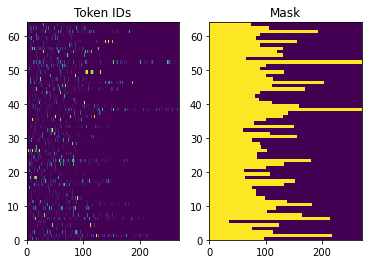

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [ ]:
def process_text(context, target):
    context = abs_text_processor(context).to_tensor()
    target = tit_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out


train_ds = train_dataset.map(process_text, tf.data.AUTOTUNE)
val_ds = val_dataset.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy()) 
    print()
    print(ex_tar_in[0, :10].numpy()) 
    print(ex_tar_out[0, :10].numpy()) 

[   9   15   25    4   10  110   22 1294    9    2]

[   2 2793    9  740   95    6  454  529  150    0]
[2793    9  740   95    6  454  529  150    3    0]


## Model components

In [ ]:
def positional_encoding(length, depth):
    depth = depth / 2
    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)
    angle_rates = 1 / (10000 ** depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = self.positional_encoding(length=2048, depth=d_model)
    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)
    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x
    def positional_encoding(self, length, depth):
      depth = depth/2

      positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
      depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

      angle_rates = 1 / (10000**depths)         # (1, depth)
      angle_rads = positions * angle_rates      # (pos, depth)

      pos_encoding = np.concatenate(
          [np.sin(angle_rads), np.cos(angle_rads)],
          axis=-1) 

      return tf.cast(pos_encoding, dtype=tf.float32)

class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)
        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()
    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

# class EncoderLayer(tf.keras.layers.Layer):
#     def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
#         super().__init__()
#         self.self_attention = GlobalSelfAttention(
#             num_heads=num_heads,
#             key_dim=d_model,
#             dropout=dropout_rate)
#         self.ffn = FeedForward(d_model, dff)
#     def call(self, x):
#         x = self.self_attention(x)
#         x = self.ffn(x)
#         return x

## Encoder

```python
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context


```



In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        # Wanneer we translator maken moeten we het volgende gebruiken:
        # self.text_processor = text_processor
        # self.vocab_size = vocab_size

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                            num_heads=num_heads,
                            dff=dff,
                            dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

    def convert_input(self, texts):
        pass

## Decoder

- https://github.com/mtjon/infompr-group-project/blob/feature/rnn/nmt_with_attention.ipynb


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
                dropout_rate=0.1):
        super(Decoder, self).__init__()
        ### TODO:
        # word_to_id etc, zie RNN decoder van Nick en Jan

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                    d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                            dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

## Transformer|

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
                input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                                num_heads=num_heads, dff=dff,
                                vocab_size=input_vocab_size,
                                dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                                num_heads=num_heads, dff=dff,
                                vocab_size=target_vocab_size,
                                dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits



## Training

In [ ]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)




In [ ]:
# Van een paper:
# d_model 1024, dff 4096, num heads 16
# https://ufal.mff.cuni.cz/pbml/110/art-popel-bojar.pdf

num_layers = 6
d_model = 128
dff = 512
num_heads = 8 # was 8
dropout_rate = 0.1
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(abs_text_processor.get_vocabulary()),
    target_vocab_size=len(tit_text_processor.get_vocabulary()),
    dropout_rate=dropout_rate)

# optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
#                                      epsilon=1e-9)





In [ ]:
# Warmup step 16000 op basis van paper advies
# beta 2 .98 zoals in paper
# https://ufal.mff.cuni.cz/pbml/110/art-popel-bojar.pdf
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
  def get_config(self):
      config = {
      'd_model': self.d_model,
      'warmup_steps': self.warmup_steps,

        }
      return config

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
# transformer.compile(
#     loss=masked_loss,
#     optimizer='adam',
#     metrics=[masked_accuracy])

transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
with tf.device('/device:GPU:0'):
    history = transformer.fit(train_ds,
                            epochs=30,
                            validation_data=val_ds,
                            callbacks=tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                patience=3))

Epoch 1/30
136/136 [==============================] - 150s 680ms/step - loss: 9.0237 - masked_accuracy: 0.0798 - val_loss: 8.7383 - val_masked_accuracy: 0.0951
Epoch 2/30
136/136 [==============================] - 73s 539ms/step - loss: 8.2828 - masked_accuracy: 0.0968 - val_loss: 7.8066 - val_masked_accuracy: 0.0951
Epoch 3/30
136/136 [==============================] - 76s 555ms/step - loss: 7.2268 - masked_accuracy: 0.0968 - val_loss: 6.9296 - val_masked_accuracy: 0.0951
Epoch 4/30
136/136 [==============================] - 74s 541ms/step - loss: 6.5822 - masked_accuracy: 0.1097 - val_loss: 6.6056 - val_masked_accuracy: 0.1196
Epoch 5/30
136/136 [==============================] - 74s 540ms/step - loss: 6.2407 - masked_accuracy: 0.1451 - val_loss: 6.3628 - val_masked_accuracy: 0.1554
Epoch 6/30
136/136 [==============================] - 75s 551ms/step - loss: 5.9345 - masked_accuracy: 0.1675 - val_loss: 6.2062 - val_masked_accuracy: 0.1760
Epoch 7/30
136/136 [=========================

In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  7458432   
                                                                 
 decoder (Decoder)           multiple                  8474752   
                                                                 
 dense_24 (Dense)            multiple                  1360563   
                                                                 
Total params: 17,293,747
Trainable params: 17,293,747
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
transformer.save('/content/gdrive/My Drive/model_19012023_01', save_format="tf")

TypeError: ignored

In [ ]:
history.history.keys()

dict_keys(['loss', 'masked_accuracy', 'val_loss', 'val_masked_accuracy'])

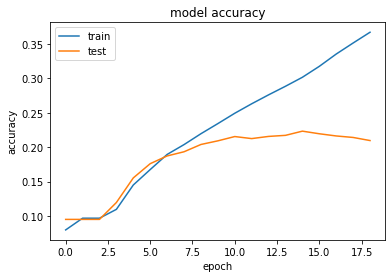

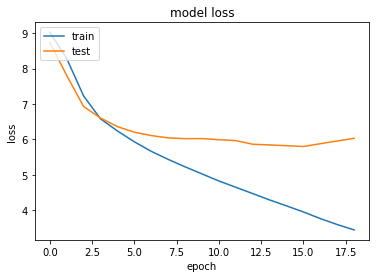

In [ ]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(history.history['masked_accuracy'])
plt.plot(history.history['val_masked_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Inference

In [ ]:
# TODO: we need to swap out the tokenizer from the original for our own tokenizer defined earlier
# However, our tokenizer does not have a detokenize method and is just a simple function
# as opposed to a Class instance with several methods.
# We will likely want to define a `detokenize` function and pass that to the Translator
# constructor as well.
class Translator(tf.Module):
  def __init__(self, tokenizer, detokenizer, transformer):
    self.tokenizer = tokenizer
    self.detokenizer = detokenizer
    self.transformer = transformer

  def __call__(self, sentence):
    # The input sentence is an abstract, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    # TODO: use our own tokenizer
    sentence = self.tokenizer(sentence).to_tensor()

    encoder_input = sentence

    # As the output language a title, initialize the output with the
    # `[START]` token.
    # TODO: look up how to tokenize this
    start_end = self.detokenizer([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    # 50 is an arbitrary break-point
    for i in tf.range(50):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())

    tit_vocab = np.array(self.detokenizer.get_vocabulary())
    tokens = tit_vocab[output.numpy()]
    text = [' '.join(tok) for tok in tokens]

    # The output shape is `(1, tokens)`.
    # text = self.detokenizer(output)[0]  # Shape: `()`.

    #tokens = self.detokenizer lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    # return text, tokens, attention_weights
    return text, attention_weights

translator = Translator(abs_text_processor, tit_text_processor, transformer)

def print_translation(abs, pred, ground_truth):
  print(f'{"Input:":15s}: {abs}')
  print(f'{"Prediction":15s}: {pred}')
  print(f'{"Ground truth":15s}: {ground_truth}')


### First Output

In [104]:
ground_truth = 'recognizing named entities in tweets'
sentence = 'the challenges of named entities recognition ( ner ) for tweets lie in the insufficient information in a tweet and the unavailability of training data . we propose to combine a k-nearest neighbors ( knn ) classifier with a linear conditional random fields ( crf ) model under a semi-supervised learning framework to tackle these challenges . the knn based classifier conducts pre-labeling to collect global coarse evidence across tweets while the crf model conducts sequential labeling to capture fine-grained information encoded in a tweet . the semi-supervised learning plus the gazetteers alleviate the lack of training data . extensive experiments show the advantages of our method over the baselines as well as the effectiveness of knn and semisupervised learning .'

In [105]:
translated_text, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : the challenges of named entities recognition ( ner ) for tweets lie in the insufficient information in a tweet and the unavailability of training data . we propose to combine a k-nearest neighbors ( knn ) classifier with a linear conditional random fields ( crf ) model under a semi-supervised learning framework to tackle these challenges . the knn based classifier conducts pre-labeling to collect global coarse evidence across tweets while the crf model conducts sequential labeling to capture fine-grained information encoded in a tweet . the semi-supervised learning plus the gazetteers alleviate the lack of training data . extensive experiments show the advantages of our method over the baselines as well as the effectiveness of knn and semisupervised learning .
Prediction     : ['[START] a hybrid approach to build a supervised approach to named entity recognition in community question answering [END]']
Ground truth   : recognizing named entities in tweets


### Second Output

In [102]:
ground_truth = 'interactive grammar development with wcdg'
sentence = 'the manual design of grammars for accurate natural language analysis is an iterative process ; while modelling decisions usually determine parser behaviour , evidence from analysing more or different input can suggest unforeseen regularities , which leads to a reformulation of rules , or even to a different model of previously analysed phenomena . we describe an implementation of weighted constraint dependency grammar that supports the grammar writer by providing display , automatic analysis , and diagnosis of dependency analyses and allows the direct exploration of alternative analyses and their status under the current grammar .'

In [103]:
translated_text, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : the manual design of grammars for accurate natural language analysis is an iterative process ; while modelling decisions usually determine parser behaviour , evidence from analysing more or different input can suggest unforeseen regularities , which leads to a reformulation of rules , or even to a different model of previously analysed phenomena . we describe an implementation of weighted constraint dependency grammar that supports the grammar writer by providing display , automatic analysis , and diagnosis of dependency analyses and allows the direct exploration of alternative analyses and their status under the current grammar .
Prediction     : ['[START] a hybrid approach to the scope of the automatic discourse structure of noun phrases in the mitre corporation [END]']
Ground truth   : interactive grammar development with wcdg


Create a function that plots the attention when a token is generated:

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label for label in in_tokens]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label for label in translated_tokens]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([19, 96])

These are the input (abstracts) tokens:

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
abs_vocab = np.array(abs_text_processor.get_vocabulary())
in_tokens = abs_text_processor(in_tokens).to_tensor()
in_tokens = abs_vocab[in_tokens.numpy()]
in_tokens

array([['the', 'manual', 'design', 'of', 'grammars', 'for', 'accurate',
        'natural', 'language', 'analysis', 'is', 'an', 'iterative',
        'process', ';', 'while', 'modelling', 'decisions', 'usually',
        'determine', 'parser', 'behaviour', ',', 'evidence', 'from',
        'analysing', 'more', 'or', 'different', 'input', 'can',
        'suggest', '[UNK]', 'regularities', ',', 'which', 'leads', 'to',
        'a', 'reformulation', 'of', 'rules', ',', 'or', 'even', 'to',
        'a', 'different', 'model', 'of', 'previously', 'analysed',
        'phenomena', '.', 'we', 'describe', 'an', 'implementation', 'of',
        'weighted', 'constraint', 'dependency', 'grammar', 'that',
        'supports', 'the', 'grammar', 'writer', 'by', 'providing',
        'display', ',', 'automatic', 'analysis', ',', 'and', 'diagnosis',
        'of', 'dependency', 'analyses', 'and', 'allows', 'the', 'direct',
        'exploration', 'of', 'alternative', 'analyses', 'and', 'their',
        'status', '

And these are the output (titles) tokens:

In [ ]:
out_tokens = tf.convert_to_tensor([translated_text])
tit_vocab = np.array(tit_text_processor.get_vocabulary())
out_tokens = tit_text_processor(out_tokens).to_tensor()
out_tokens = tit_vocab[out_tokens.numpy()]
out_tokens

array([['[START]', '[UNK]', 'a', 'hybrid', 'approach', 'to', 'the',
        'scope', 'of', 'the', 'automatic', 'discourse', 'structure',
        'of', 'noun', 'phrases', 'in', 'the', 'mitre', 'corporation',
        '[UNK]', '[END]']], dtype='<U30')

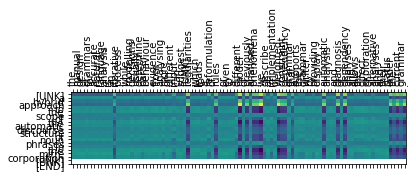

In [ ]:
plot_attention_head(in_tokens[0], out_tokens[0], attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  # in_tokens = tf.convert_to_tensor([sentence])
  # in_tokens = tokenizer(in_tokens).to_tensor()
  # tit_vocab = np.array(tit_text_processor.get_vocabulary())
  # out_tokens = tit_vocab[in_tokens.numpy()]
  # in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_attention_weights(sentence,
                       out_tokens,
                       attention_weights[0])

ValueError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f2617dc5280> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 1152x576 with 1 Axes>

The model can handle unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset, and the model attempts to transliterate them even without a shared vocabulary. For example:

In [ ]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## Export the model

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model).

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [ ]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [ ]:
translator('este é o primeiro livro que eu fiz.').numpy()

In [ ]:
tf.saved_model.save(translator, export_dir='translator')

In [ ]:
reloaded = tf.saved_model.load('translator')

In [ ]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

## Conclusion

In this tutorial you learned about:

* The Transformers and their significance in machine learning
* Attention, self-attention and multi-head attention
* Positional encoding with embeddings
* The encoder-decoder architecture of the original Transformer
* Masking in self-attention
* How to put it all together to translate text

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.
- If the input has a temporal/spatial relationship, like text or images, some positional encoding must be added or the model will effectively see a bag of words.

If you want to practice, there are many things you could try with it. For example:

* Use a different dataset to train the Transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805)t beam search to get better predictions.

There are a wide variety of Transformer-based models, many of which improve upon the 2017 version of the original Transformer with encoder-decoder, encoder-only and decoder-only architectures.

Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732) (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238) (Phuong and Hutter, 2022).
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683) (Raffel et al., 2019)

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html).
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html)
* [MUM](https://blog.google/products/search/introducing-mum/)
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers) with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode)
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html)
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2)
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html)
